In [ ]:
!pip install tensorflow==2.8.0
!pip install efficientnet
!pip install --upgrade wandb

In [2]:
!tree / > files.txt

In [2]:
# !pip install wandb==0.15.0 

In [3]:
import os
print(os.environ)

environ({'LIBRARY_PATH': ':/opt/conda/lib', 'PIP_ROOT_USER_ACTION': 'ignore', 'MKL_THREADING_LAYER': 'GNU', 'KAGGLE_URL_BASE': 'https://www.kaggle.com', 'KAGGLE_KERNEL_RUN_TYPE': 'Interactive', 'MPLBACKEND': 'agg', 'HOSTNAME': '30cf356e8ea7', 'GCSFUSE_METADATA_IMAGE_TYPE': 'DLC', 'SHLVL': '1', 'LD_LIBRARY_PATH': '/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib', 'GIT_COMMIT': '5b37fe29fefdef02f55a8db1fff9f9b63826f777', 'ENABLE_MULTI_ENV': 'false', 'HOME': '/root', 'TENSORFLOW_VERSION': '2.12.0', 'KMP_SETTINGS': 'false', 'TESSERACT_PATH': '/usr/bin/tesseract', 'KAGGLE_DATA_PROXY_URL': 'https://dp.kaggle.net', 'NODE_OPTIONS': '--max-old-space-size=4096', 'KMP_BLOCKTIME': '0', 'TF_CPP_MIN_LOG_LEVEL': '2', 'BUILD_DATE': '20230905-170153', 'KAGGLE_GCP_ZONE': 'us-west1-b', 'KAGGLE_CONTAINER_NAME': 'kaggle_lDlHbyQJiZMMpzCIlr8Me60t48VYLTLYZz29qJctkoY-147033544-webtier', '_': '/opt/conda/bin/jupyter', 'ANACO

In [1]:
import os
import re
import random
import pandas as pd
import numpy as np
import json
import math
import string
import uuid


### Tensorflow Imports
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,confusion_matrix
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications import MobileNet


### External models
import efficientnet.tfkeras as efn


### Matplotlib Imports
import matplotlib
import matplotlib.pyplot as plt


### Kaggle specific imports
if os.environ.get('KAGGLE_DOCKER_IMAGE', None):
    from kaggle_datasets import KaggleDatasets
    DATA_PATH = KaggleDatasets().get_gcs_path()
    DATA_PATH = DATA_PATH + '/mitdb128x128'


ModuleNotFoundError: No module named 'efficientnet'

In [2]:
hparams = {
    "backbone" : "b0",
    "batch_size" : 32,
    "epochs" : 35,
    "img_size" : 128,
    "lr" : 0.0029,
    "optimizer" : "adam",
    "seed": 127
}

In [3]:
import wandb
import os

class WandBConfigurations():
    def __init__(self, exp_name = "ECG_BEAT_CLASSIFICATION_PAPER_COMMENTS"):
        self.EXPERIMENT_NAME = exp_name
        os.environ["WANDB_API_KEY"] = "221507f411c2ddcc0c17238e115a12c528a482f6"
#         os.environ["WANDB_NOTEBOOK_NAME"] = ""
        wandb.login()
        
WB = WandBConfigurations()

wandb: Currently logged in as: shreya-srivas02. Use `wandb login --relogin` to force relogin


In [19]:
!tree /kaggle

/kaggle
├── input
│   └── mitdb128x128
│       └── mitdb_128x128
│           ├── data-mitdb.csv
│           ├── data-mitdb.json
│           ├── sample_image_for_heart_beat.jpeg
│           ├── splitted_data.csv
│           ├── trainfile_class10_fold0_6117.tfrec
│           ├── trainfile_class10_fold1_6116.tfrec
│           ├── trainfile_class10_fold2_6116.tfrec
│           ├── trainfile_class10_fold3_6116.tfrec
│           ├── trainfile_class10_fold4_6116.tfrec
│           ├── trainfile_class10_fold5_6116.tfrec
│           ├── trainfile_class10_fold6_6116.tfrec
│           ├── trainfile_class10_fold7_6117.tfrec
│           ├── trainfile_class10_fold8_6116.tfrec
│           └── trainfile_class10_fold9_6116.tfrec
├── lib
│   └── kaggle
│       └── gcp.py
└── working

6 directories, 15 files


In [7]:
  run_ = wandb.init(
      project= WB.EXPERIMENT_NAME,
      reinit=True,
      dir = "/root",
      allow_val_change = True
  )

In [8]:
wandb.save("kaggle.ipynb")

[]

In [ ]:
!tree / |

In [13]:

def id_generator(size=6):
    return str(uuid.uuid4())[:size]
MODELS = []

hparams = {
    "backbone" : "b0",
    "batch_size" : 32,
    "epochs" : 35,
    "img_size" : 128,
    "lr" : 0.0029,
    "optimizer" : "adam",
    "seed": 127
}

def get_optimizer():
    if hparams['optimizer'] == 'adam':
        return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])
    if hparams['optimizer'] == 'rmsprop':
        return tf.keras.optimizers.RMSprop(learning_rate=hparams["lr"])
    if hparams['optimizer'] == 'adagrad':
        return tf.keras.optimizers.Adagrad(learning_rate=hparams["lr"])
    if hparams['optimizer'] == 'adadelta':
        return tf.keras.optimizers.Adadelta(learning_rate=hparams["lr"])

    return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])

DO_VAL_SPLIT = True
TRAIN_FILES = sorted(tf.io.gfile.glob('/kaggle/input/mitdb128x128/mitdb_128x128/train*.tfrec'))[:-1]
TOTAL_TRAIN_IMG = 48929
TOTAL_VAL_IMG = 6116
TOTAL_TEST_IMG = 6116
BACKBONE = hparams['backbone']
IMG_TRAIN_SHAPE = [hparams["img_size"],hparams["img_size"]]
DO_FINETUNE = True
BATCH_SIZE = hparams["batch_size"] # 16
EPOCHES = hparams["epochs"]
SEED = hparams["seed"]
LOSS = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER = get_optimizer()
ACCURACY = []
CALLBACKS = []
STRATEGY = None
FOLDS = 9

print(TRAIN_FILES)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    STRATEGY = strategy
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    # wandb.config.hardware = 'TPU'
else:
    strategy = tf.distribute.get_strategy()


def seed_everything():
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(a=SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)

seed_everything()


def process_training_data(data_file):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        'target10': tf.io.FixedLenFeature([], tf.int64),
        'gender' : tf.io.FixedLenFeature([], tf.int64),
        'age_interval' : tf.io.FixedLenFeature([], tf.int64),
    }
    data = tf.io.parse_single_example(data_file, LABELED_TFREC_FORMAT)
    img = tf.image.decode_jpeg(data['image'], channels=1)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [*IMG_TRAIN_SHAPE, 1])

    age = tf.cast(data['age_interval'], tf.float32) / 10.0
    sex = tf.cast(data['gender'], tf.float32) / 1.0
    tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
    tabular_data = tf.stack(tab_data)

    target10 = tf.one_hot(data['target10'], depth=10)

    return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10 }

def get_cosine_schedule_with_warmup(lr = 0.00004, num_warmup_steps = 0 , num_training_steps = EPOCHES, num_cycles=0.5):
    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return (float(epoch) / float(max(1, num_warmup_steps))) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return lrfn

lrfn = get_cosine_schedule_with_warmup(lr=hparams['lr'])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
CALLBACKS.append(lr_schedule)


def se_block(x, ratio=16):
    """Creates a squeeze and excitation block."""
    channels = x.shape[-1]
    se_shape = (1, 1, channels)
    
    se = tf.keras.layers.GlobalAveragePooling2D()(x)
    se = tf.keras.layers.Reshape(se_shape)(se)
    se = tf.keras.layers.Dense(channels // ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(channels, activation='sigmoid')(se)
    
    return tf.keras.layers.multiply([x, se])

def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second convolution layer
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
                           
    x = se_block(x)

    # Adding the shortcut to the output
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x

from tensorflow.keras.layers import Input, Conv1D, Add, Activation

# Define the residual block for the TCN
def residual_block(x, filters, kernel_size=3, dilation_rate=1):
    prev_x = x
    for k in range(2):
        x = Conv1D(filters=filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding='causal',
                   activation='relu')(x)  # 'causal' for time-series
        
    # Ensure the output and input are of the same shape
    if x.shape[-1] != prev_x.shape[-1]:
        prev_x = Conv1D(filters=filters,
                        kernel_size=1)(prev_x)
        
    return Add()([prev_x, x])

from tensorflow.keras.layers import UpSampling1D, Add, Conv2D

def create_fpn(features, num_channels=32):
    pyramid = []
    for feature in features[::-1]:
        if pyramid:
            feature = Add()([UpSampling1D()(pyramid[-1]), feature])
        feature = Conv1D(num_channels, 32, padding='same')(feature)
        pyramid.append(feature)
    return pyramid[::-1]

from tensorflow.keras.layers import Layer

class SelfAttention(Layer):
    def __init__(self, head_size, num_heads):
        super(SelfAttention, self).__init__()
        self.head_size = head_size
        self.num_heads = num_heads
        
    def build(self, input_shape):
        self.w_q = self.add_weight(name='w_q', shape=(input_shape[-1], self.head_size * self.num_heads))
        self.w_k = self.add_weight(name='w_k', shape=(input_shape[-1], self.head_size * self.num_heads))
        self.w_v = self.add_weight(name='w_v', shape=(input_shape[-1], self.head_size * self.num_heads))
        super(SelfAttention, self).build(input_shape)
        
    def call(self, inputs):
        q = tf.matmul(inputs, self.w_q)
        k = tf.matmul(inputs, self.w_k)
        v = tf.matmul(inputs, self.w_v)
        
        q = tf.reshape(q, [-1, self.num_heads, self.head_size])
        k = tf.reshape(k, [-1, self.num_heads, self.head_size])
        v = tf.reshape(v, [-1, self.num_heads, self.head_size])
        
        attn = tf.nn.softmax(tf.matmul(q, k, transpose_b=True) / tf.sqrt(float(self.head_size)))
        output = tf.matmul(attn, v)
        output = tf.reshape(output, [-1, self.head_size * self.num_heads])
        return output


class SelfAttentiveCCALayer(tf.keras.layers.Layer):
    def __init__(self,output_dim, **kwargs):
        self.output_dim = output_dim
        super(SelfAttentiveCCALayer, self).__init__(**kwargs)
        self.self_attention1 = SelfAttention(head_size=256, num_heads=1)
        
    def build(self, input_shape):
        # Create a trainable weight variable for each modality
        self.kernel_1 = self.add_weight(name='kernel_1',
                                        shape=(input_shape[0][-1], input_shape[0][-1]),
                                        initializer=tf.keras.initializers.Identity(),
                                        trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2',
                                        shape=(input_shape[1][-1], input_shape[1][-1]),
                                        initializer=tf.keras.initializers.Identity(),
                                        trainable=False)
        self.weight1 = self.add_weight(name='weight1',
                                             shape=(1,),
                                             initializer=tf.keras.initializers.Zeros(),
                                             trainable=True)
        self.weight2 = self.add_weight(name='weight2',
                                             shape=(1,),
                                             initializer=tf.keras.initializers.Zeros(),
                                             trainable=True)
        super(SelfAttentiveCCALayer, self).build(input_shape)

    def call(self, inputs):
        attn_out1 = self.self_attention1(inputs[0])
        proj_1 = K.dot(attn_out1, self.kernel_1)
        proj_1 = tf.nn.sigmoid(proj_1)
        proj_2 = K.dot(inputs[1], self.kernel_2)
        combined = [self.weight1 * proj_1, self.weight2 * proj_2]
        return tf.keras.layers.concatenate(combined)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0] + input_shape[1][0], input_shape[0][-1] + input_shape[1][-1])

class CCALayer(tf.keras.layers.Layer):
    def __init__(self,output_dim, **kwargs):
        self.output_dim = output_dim
        super(CCALayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for each modality
        self.kernel_1 = self.add_weight(name='kernel_1',
                                        shape=(input_shape[0][-1],  self.output_dim),
                                        initializer=tf.keras.initializers.Identity(),
                                        trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2',
                                        shape=(input_shape[1][-1],  self.output_dim),
                                        initializer=tf.keras.initializers.Identity(),
                                        trainable=True)
#         self.weight1 = self.add_weight(name='weight1',
#                                              shape=(1,),
#                                              initializer=tf.keras.initializers.Zeros(),
#                                              trainable=True)
#         self.weight2 = self.add_weight(name='weight2',
#                                              shape=(1,),
#                                              initializer=tf.keras.initializers.Zeros(),
#                                              trainable=True)
        super(CCALayer, self).build(input_shape)

    def call(self, inputs):
        # inputs is a list of two feature tensors: [features_1, features_2]
        proj_1 = K.dot(inputs[0], self.kernel_1)
#         proj_1 = tf.nn.sigmoid(proj_1)
        proj_2 = K.dot(inputs[1], self.kernel_2)
#         combined = [self.weight1 * proj_1, self.weight2 * proj_2]
        combined = [proj_1, proj_2]
#         proj_2 = K.dot(inputs[1], self.kernel_2)
#         self.add_loss(-tf.reduce_mean(tf.linalg.diag_part(tf.matmul(proj_1, proj_2, transpose_a=True))) / self.output_dim)  # Maximize correlation
        return tf.keras.layers.concatenate(combined)
#         return self.combine_weight * proj_1
#         return combined
    
    def compute_output_shape(self, input_shape):
#         return [(input_shape[0][0], self.output_dim), (input_shape[1][0], self.output_dim)]
        return (input_shape[0][0], 2*self.output_dim)
#         return (input_shape[0][0], self.output_dim)

from tensorflow.keras.layers import Input, DepthwiseConv2D, Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense
def depthwise_separable_conv(x, filters, stride):
    # Depthwise Convolution
    x = DepthwiseConv2D((3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Pointwise Convolution
    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x

def MYMobileNetV1(inp1):
    # Initial Conv Layer
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inp1)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Depthwise Separable Convolution Blocks
    x = depthwise_separable_conv(x, 64, (1, 1))
    x = depthwise_separable_conv(x, 128, (2, 2))
    x = depthwise_separable_conv(x, 128, (1, 1))
    x = depthwise_separable_conv(x, 256, (2, 2))
#     x = depthwise_separable_conv(x, 256, (1, 1))
#     x = depthwise_separable_conv(x, 512, (2, 2))

#     # Repeating the same block for additional 5 times
#     for _ in range(5):
#         x = depthwise_separable_conv(x, 512, (1, 1))

#     x = depthwise_separable_conv(x, 1024, (2, 2))
#     x = depthwise_separable_conv(x, 1024, (1, 1))

    return x


class DependencyLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DependencyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                     shape=(input_shape[1][-1], self.output_dim),
                                     initializer='uniform',
                                     trainable=True)
        super(DependencyLayer, self).build(input_shape)

    def call(self, inputs):
        input1, input2 = inputs
        influence = tf.linalg.matmul(input2, self.kernel)
        influenced_input1 = tf.math.matmul(input1, influence)
        return influenced_input1
    
    def compute_output_shape(self, input_shape):
#         return [(input_shape[0][0], self.output_dim), (input_shape[1][0], self.output_dim)]
        return (input_shape[0][-1], input_shape[0][0])
#         return (input_shape[0][0], self.output_dim)

class GatingLayer(Layer):
    def __init__(self, **kwargs):
        super(GatingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                     shape=(input_shape[1][-1], input_shape[0][-1]),
                                     initializer='uniform',
                                     trainable=True)
        super(GatingLayer, self).build(input_shape)

    def call(self, inputs):
        image_features, metadata = inputs
        gating_values = tf.linalg.matmul(metadata, self.kernel)
        gating_values = tf.nn.sigmoid(gating_values)  # Make gating values sum to 1
        return image_features * gating_values

def multimodeleffbx():
    inp1  = tf.keras.layers.Input(shape = (*IMG_TRAIN_SHAPE, 1), name='inp1')
    inp2  = tf.keras.layers.Input(shape = (2,), name='inp2')
    x1 = MYMobileNetV1(inp1)
    
    # Assuming you want to apply TCN on the image input, you might need to reshape it
#     x1 = tf.keras.layers.Reshape((-1, 128))(inp1)  # Adjust the shape based on how you want to apply the TCN
    
#     # Apply multiple residual blocks with increasing dilation rates
#     x1 = residual_block(x1, filters=32, dilation_rate=1)
#     x2 = residual_block(x1, filters=32, dilation_rate=2)
#     x3 = residual_block(x2, filters=32, dilation_rate=4)
#     x1 = residual_block(x3, filters=32, dilation_rate=8)
        
#     features = [x1, x2, x3, x4]  # Add your layer names
    
# #     # Create the FPN using extracted feature maps
#     fpn_features = create_fpn(features)
    
# #     # You can concatenate FPN features, or use them separately
#     x1 = tf.keras.layers.Concatenate(axis=-1)(fpn_features)
#     print(x.output_shape)

#     x1 = tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding="same")(inp1)
#     x1 = tf.keras.layers.BatchNormalization()(x1)
#     x1 = tf.keras.layers.ReLU()(x1)
#     x1 = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding="same")(x1)
                           
#     # Multi-Scale Feature Integration
#     x_small = tf.keras.layers.MaxPooling2D(4)(x1)
#     x_medium = tf.keras.layers.MaxPooling2D(2)(x1)

#     # Residual Blocks
#     x_large = residual_block(x1, 64)
#     x_large = residual_block(x_large, 64)
#     x_large = residual_block(x_large, 64)
    
#     # Global Average Pooling layer
#     x1 = tf.keras.layers.Concatenate()([
#         tf.keras.layers.GlobalAveragePooling2D()(x_small),
#         tf.keras.layers.GlobalAveragePooling2D()(x_medium),
#         tf.keras.layers.GlobalAveragePooling2D()(x_large)
#     ])

    x1 = tf.keras.layers.GlobalMaxPooling2D()(x1)
    x1    = tf.keras.layers.Dropout(0.1)(x1)

    x2    = tf.keras.layers.Dense(8)(inp2) ##more layers to come after that
    x2     = tf.keras.layers.concatenate([x2, inp2])
    
    x = GatingLayer()([x1, x2])

#     x     = tf.keras.layers.concatenate(cca_layer)
#     x    = tf.keras.layers.Dense(128)(x)
    x    = tf.keras.layers.Dense(64)(x)
    x     = tf.keras.layers.Dropout(0.15)(x)

    output10     = tf.keras.layers.Dense(10, activation='softmax', name='target10')(x)

    model = tf.keras.models.Model(inputs = [inp1, inp2], outputs = [output10])

    return model


def cca_loss(y_true, y_pred):
    return 0.0 

# def fitengine(model, traindataset, valdataset = None, istraining = True):
#     model.compile(
#         optimizer   =  OPTIMIZER,
#         loss        =  LOSS,
#         metrics     =  ACCURACY
#     )

#     history = model.fit(
#                 traindataset,
#                 epochs            =   EPOCHES,
#                 steps_per_epoch   =   TOTAL_TRAIN_IMG//BATCH_SIZE,
#                 callbacks         =   CALLBACKS,
#                 validation_data   =   valdataset,
#                 validation_steps = (TOTAL_VAL_IMG)//(BATCH_SIZE) + 1,
#                 verbose           =   1
#             )

#     return history

# skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
# FOLDS_DICT = {}
# for fold_number,(idxT,idxV) in enumerate(skf.split(np.arange(len(TRAIN_FILES)))):
#     FOLDS_DICT['fold_{}'.format(fold_number)] = {
#                                             "trainfiles" : [TRAIN_FILES[x] for x in idxT],
#                                             "valfiles"   : [TRAIN_FILES[x] for x in idxV]
#                                             }

# for fold_number in range(1):
#   print(FOLDS_DICT['fold_{}'.format(fold_number)]['trainfiles'])
#   print(FOLDS_DICT['fold_{}'.format(fold_number)]['valfiles'])
#   HISTORY = {}

#   run_ = wandb.init(
#       project= EXPERIMENT_NAME,
#       reinit=True,
#       dir = "/root",
#       allow_val_change = True
#   )

#   if STRATEGY is not None:
#       with strategy.scope():
#           x2 = tf.keras.metrics.Precision(name='precision')
#           x3 = tf.keras.metrics.BinaryAccuracy(name='accuracy')
#           x4 = tf.keras.metrics.Recall(name='sensitivity')

#           ACCURACY.append(x2)
#           ACCURACY.append(x3)
#           ACCURACY.append(x4)

#           model = multimodeleffbx()
#   else:
#       x2 = tf.keras.metrics.Precision(name='precision')
#       x3 = tf.keras.metrics.BinaryAccuracy(name='accuracy')
#       x4 = tf.keras.metrics.Recall(name='sensitivity')
#       x4 = tf.keras.metrics.Recall(name='sensitivity')

#       ACCURACY.append(x2)
#       ACCURACY.append(x3)
#       ACCURACY.append(x4)

#       model = multimodeleffbx()

#   CALLBACKS.append(tf.keras.callbacks.ModelCheckpoint(
#                                   'model-%s.h5'%(fold_number), monitor='val_loss', verbose=1, save_best_only=True,
#                                   save_weights_only=True, mode='min', save_freq='epoch'))

#   CALLBACKS.append(WandbCallback(save_weights_only=True,
#                                                 log_weights=True,
#                                                 log_evaluation=True))




#   ignore_order = tf.data.Options()
#   ignore_order.experimental_deterministic = False
#   train_dataset = (
#       tf.data.TFRecordDataset(
#           FOLDS_DICT["fold_{}".format(fold_number)]["trainfiles"],
#           num_parallel_reads=tf.data.experimental.AUTOTUNE
#       ).with_options(
#           ignore_order
#       ).map(
#           process_training_data,
#           num_parallel_calls=tf.data.experimental.AUTOTUNE
#       ).repeat(
#       ).shuffle(
#           SEED
#       ).batch(
#           BATCH_SIZE
#       ).prefetch(
#           tf.data.experimental.AUTOTUNE
#       )
#   )

#   ignore_order = tf.data.Options()
#   val_dataset = (
#       tf.data.TFRecordDataset(
#           FOLDS_DICT["fold_{}".format(fold_number)]["valfiles"],
#           num_parallel_reads=tf.data.experimental.AUTOTUNE
#       ).with_options(
#           ignore_order
#       ).map(
#           process_training_data,
#           num_parallel_calls=tf.data.experimental.AUTOTUNE
#       ).batch(
#           BATCH_SIZE
#       ).prefetch(
#           tf.data.experimental.AUTOTUNE
#       )
#   )

#   print("##"*30)

#   history = fitengine(model, train_dataset, valdataset=val_dataset) #training model
#   MODELS.append(model)

#   print('##'*30)


#   run_.finish()



2.8.0
['/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold0_6117.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold1_6116.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold2_6116.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold3_6116.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold4_6116.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold5_6116.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold6_6116.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold7_6117.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold8_6116.tfrec']
['/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold0_6117.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold1_6116.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/trainfile_class10_fold2_6116.tfrec', '/kaggle/input/mitdb128x128/mitdb_128x128/tr

wandb: WARNING WandbCallback is unable to log validation data. When using a generator for validation_data, you must pass validation_steps


############################################################
Epoch 1/35
1529/1529 [==============================] - ETA: 0s - loss: 0.4656 - precision: 0.8935 - accuracy: 0.9749 - sensitivity: 0.8501
Epoch 1: val_loss improved from inf to 2.48347, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 66s 42ms/step - loss: 0.4656 - precision: 0.8935 - accuracy: 0.9749 - sensitivity: 0.8501 - val_loss: 2.4835 - val_precision: 0.2984 - val_accuracy: 0.8664 - val_sensitivity: 0.2487 - lr: 0.0029
Epoch 2/35
1529/1529 [==============================] - ETA: 0s - loss: 0.2183 - precision: 0.9414 - accuracy: 0.9871 - sensitivity: 0.9289
Epoch 2: val_loss did not improve from 2.48347
1529/1529 [==============================] - 61s 40ms/step - loss: 0.2183 - precision: 0.9414 - accuracy: 0.9871 - sensitivity: 0.9289 - val_loss: 3.4994 - val_precision: 0.3166 - val_accuracy: 0.8706 - val_sensitivity: 0.2541 - lr: 0.0029
Epoch 3/35
1529/1529 [==============================] - ETA: 0s - loss: 0.1754 - precision: 0.9521 - accuracy: 0.9896 - sensitivity: 0.9433
Epoch 3: val_loss improved from 2.48347 to 2.06322, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 65s 42ms/step - loss: 0.1754 - precision: 0.9521 - accuracy: 0.9896 - sensitivity: 0.9433 - val_loss: 2.0632 - val_precision: 0.6056 - val_accuracy: 0.9207 - val_sensitivity: 0.5943 - lr: 0.0029
Epoch 4/35
1529/1529 [==============================] - ETA: 0s - loss: 0.1514 - precision: 0.9581 - accuracy: 0.9908 - sensitivity: 0.9499
Epoch 4: val_loss improved from 2.06322 to 1.97982, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


1529/1529 [==============================] - 104s 68ms/step - loss: 0.1514 - precision: 0.9581 - accuracy: 0.9908 - sensitivity: 0.9499 - val_loss: 1.9798 - val_precision: 0.6120 - val_accuracy: 0.9096 - val_sensitivity: 0.2618 - lr: 0.0028
Epoch 5/35
 199/1529 [==>...........................] - ETA: 51s - loss: 0.1518 - precision: 0.9609 - accuracy: 0.9913 - sensitivity: 0.9523

wandb: Network error (ReadTimeout), entering retry loop.


1529/1529 [==============================] - ETA: 0s - loss: 0.1339 - precision: 0.9635 - accuracy: 0.9921 - sensitivity: 0.9567
Epoch 5: val_loss improved from 1.97982 to 1.78370, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


1529/1529 [==============================] - 104s 68ms/step - loss: 0.1339 - precision: 0.9635 - accuracy: 0.9921 - sensitivity: 0.9567 - val_loss: 1.7837 - val_precision: 0.4937 - val_accuracy: 0.8989 - val_sensitivity: 0.4315 - lr: 0.0028
Epoch 6/35
1529/1529 [==============================] - ETA: 0s - loss: 0.1226 - precision: 0.9653 - accuracy: 0.9925 - sensitivity: 0.9597
Epoch 6: val_loss improved from 1.78370 to 0.44911, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


1529/1529 [==============================] - 103s 68ms/step - loss: 0.1226 - precision: 0.9653 - accuracy: 0.9925 - sensitivity: 0.9597 - val_loss: 0.4491 - val_precision: 0.8729 - val_accuracy: 0.9695 - val_sensitivity: 0.8138 - lr: 0.0028
Epoch 7/35
1529/1529 [==============================] - ETA: 0s - loss: 0.1120 - precision: 0.9684 - accuracy: 0.9933 - sensitivity: 0.9641
Epoch 7: val_loss did not improve from 0.44911
1529/1529 [==============================] - 61s 40ms/step - loss: 0.1120 - precision: 0.9684 - accuracy: 0.9933 - sensitivity: 0.9641 - val_loss: 1.8133 - val_precision: 0.6681 - val_accuracy: 0.9322 - val_sensitivity: 0.6408 - lr: 0.0027
Epoch 8/35
1529/1529 [==============================] - ETA: 0s - loss: 0.1040 - precision: 0.9710 - accuracy: 0.9938 - sensitivity: 0.9667
Epoch 8: val_loss improved from 0.44911 to 0.16251, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


1529/1529 [==============================] - 101s 66ms/step - loss: 0.1040 - precision: 0.9710 - accuracy: 0.9938 - sensitivity: 0.9667 - val_loss: 0.1625 - val_precision: 0.9507 - val_accuracy: 0.9897 - val_sensitivity: 0.9460 - lr: 0.0026
Epoch 9/35
1529/1529 [==============================] - ETA: 0s - loss: 0.0950 - precision: 0.9734 - accuracy: 0.9943 - sensitivity: 0.9696
Epoch 9: val_loss did not improve from 0.16251
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0950 - precision: 0.9734 - accuracy: 0.9943 - sensitivity: 0.9696 - val_loss: 0.4627 - val_precision: 0.8707 - val_accuracy: 0.9705 - val_sensitivity: 0.8280 - lr: 0.0025
Epoch 10/35
1529/1529 [==============================] - ETA: 0s - loss: 0.0901 - precision: 0.9743 - accuracy: 0.9945 - sensitivity: 0.9709
Epoch 10: val_loss did not improve from 0.16251
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0901 - precision: 0.9743 - accuracy: 0.9945 - sensitivity: 0.9709 - val_lo

wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 84s 55ms/step - loss: 0.0810 - precision: 0.9765 - accuracy: 0.9950 - sensitivity: 0.9732 - val_loss: 0.1350 - val_precision: 0.9654 - val_accuracy: 0.9928 - val_sensitivity: 0.9624 - lr: 0.0024
Epoch 12/35
1529/1529 [==============================] - ETA: 0s - loss: 0.0769 - precision: 0.9773 - accuracy: 0.9952 - sensitivity: 0.9747
Epoch 12: val_loss improved from 0.13502 to 0.12616, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 64s 42ms/step - loss: 0.0769 - precision: 0.9773 - accuracy: 0.9952 - sensitivity: 0.9747 - val_loss: 0.1262 - val_precision: 0.9685 - val_accuracy: 0.9933 - val_sensitivity: 0.9644 - lr: 0.0022
Epoch 13/35
1528/1529 [============================>.] - ETA: 0s - loss: 0.0696 - precision: 0.9798 - accuracy: 0.9957 - sensitivity: 0.9771
Epoch 13: val_loss did not improve from 0.12616
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0696 - precision: 0.9797 - accuracy: 0.9957 - sensitivity: 0.9771 - val_loss: 0.2604 - val_precision: 0.9333 - val_accuracy: 0.9861 - val_sensitivity: 0.9272 - lr: 0.0021
Epoch 14/35
1529/1529 [==============================] - ETA: 0s - loss: 0.0633 - precision: 0.9811 - accuracy: 0.9960 - sensitivity: 0.9790
Epoch 14: val_loss did not improve from 0.12616
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0633 - precision: 0.9811 - accuracy: 0.9960 - sensitivity: 0.9790 - val_l

wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 65s 42ms/step - loss: 0.0472 - precision: 0.9853 - accuracy: 0.9969 - sensitivity: 0.9836 - val_loss: 0.1247 - val_precision: 0.9753 - val_accuracy: 0.9949 - val_sensitivity: 0.9735 - lr: 0.0016
Epoch 18/35
1529/1529 [==============================] - ETA: 0s - loss: 0.0433 - precision: 0.9868 - accuracy: 0.9972 - sensitivity: 0.9854
Epoch 18: val_loss did not improve from 0.12474
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0433 - precision: 0.9868 - accuracy: 0.9972 - sensitivity: 0.9854 - val_loss: 0.1579 - val_precision: 0.9615 - val_accuracy: 0.9920 - val_sensitivity: 0.9588 - lr: 0.0015
Epoch 19/35
1529/1529 [==============================] - ETA: 0s - loss: 0.0378 - precision: 0.9875 - accuracy: 0.9974 - sensitivity: 0.9867
Epoch 19: val_loss did not improve from 0.12474
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0378 - precision: 0.9875 - accuracy: 0.9974 - sensitivity: 0.9867 - val_l

wandb: Adding directory to artifact (/root/wandb/run-20231018_011730-ahenxgvj/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 64s 42ms/step - loss: 0.0222 - precision: 0.9929 - accuracy: 0.9985 - sensitivity: 0.9923 - val_loss: 0.1175 - val_precision: 0.9776 - val_accuracy: 0.9955 - val_sensitivity: 0.9773 - lr: 8.8011e-04
Epoch 24/35
1529/1529 [==============================] - ETA: 0s - loss: 0.0173 - precision: 0.9948 - accuracy: 0.9989 - sensitivity: 0.9943
Epoch 24: val_loss did not improve from 0.11754
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0173 - precision: 0.9948 - accuracy: 0.9989 - sensitivity: 0.9943 - val_loss: 0.1272 - val_precision: 0.9782 - val_accuracy: 0.9956 - val_sensitivity: 0.9773 - lr: 7.6289e-04
Epoch 25/35
1529/1529 [==============================] - ETA: 0s - loss: 0.0149 - precision: 0.9950 - accuracy: 0.9990 - sensitivity: 0.9945
Epoch 25: val_loss did not improve from 0.11754
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0149 - precision: 0.9950 - accuracy: 0.9990 - sensitivity: 0.9945

accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
precision,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
sensitivity,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
val_accuracy,▁▁▄▃▃▇▅█▇███▇██▇███████████████████
val_loss,▆█▅▅▄▂▅▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▄▄▃▇▅█▇██████▇███████████████████
val_sensitivity,▁▁▄▁▃▆▅█▇██████▇███████████████████
accuracy,0.99981


In [67]:
run_.finish()

In [62]:
multimodeleffbx().summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 64, 64, 32)   320         ['inp1[0][0]']                   
                                                                                                  
 batch_normalization_124 (Batch  (None, 64, 64, 32)  128         ['conv2d_69[0][0]']              
 Normalization)                                                                                   
                                                                                           

In [ ]:
model.summary()

In [11]:
import wandb
run = wandb.init()
artifact = run.use_artifact('shreya-srivas02/ECG_BEAT_CLASSIFICATION_PAPER_COMMENTS/model-lilac-serenity-46:v7', type='model')
artifact_dir = artifact.download()

wandb:   4 of 4 files downloaded.  


In [12]:
model0 = tf.keras.models.load_model('./artifacts/model-lilac-serenity-46:v7')

In [47]:
model_till_last_epoch = model
SAVED_MODEL_LOC = "/kaggle/working/model-0.h5"
model = multimodeleffbx()
model.load_weights(SAVED_MODEL_LOC)

In [48]:
model.layers[-4].get_weights()

[array([[ 0.34099966,  0.35806328, -0.64132684, ...,  0.53833324,
         -0.48714924,  0.2555556 ],
        [-0.22259298,  0.6418431 , -0.54863226, ...,  0.01287498,
         -0.67329305,  1.3271586 ],
        [ 0.1477995 ,  0.43886405,  1.0501593 , ..., -0.77713877,
         -0.03431987,  0.05665112],
        ...,
        [ 0.02020958, -0.00601517,  0.02160772, ...,  1.0120411 ,
          0.01292967, -0.03050697],
        [ 0.04812548,  0.03095824, -0.9921004 , ..., -0.17983432,
          0.6540935 ,  0.1910245 ],
        [-0.5215914 ,  0.13641198, -0.10008233, ..., -0.6478999 ,
         -0.17243706,  0.9624469 ]], dtype=float32),
 array([-0.10074648], dtype=float32),
 array([-0.2950195], dtype=float32),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 

48/48 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           /       0.99      1.00      0.99       382
           A       0.88      0.78      0.83       245
           F       0.92      0.79      0.85        76
           L       0.99      0.99      0.99       801
           N       0.97      0.98      0.97      3252
           R       0.98      0.99      0.99       586
           V       0.93      0.93      0.93       713
           a       0.73      0.73      0.73        11
           f       0.86      0.86      0.86        21
           j       0.75      0.52      0.61        29

    accuracy                           0.96      6116
   macro avg       0.90      0.86      0.88      6116
weighted avg       0.96      0.96      0.96      6116



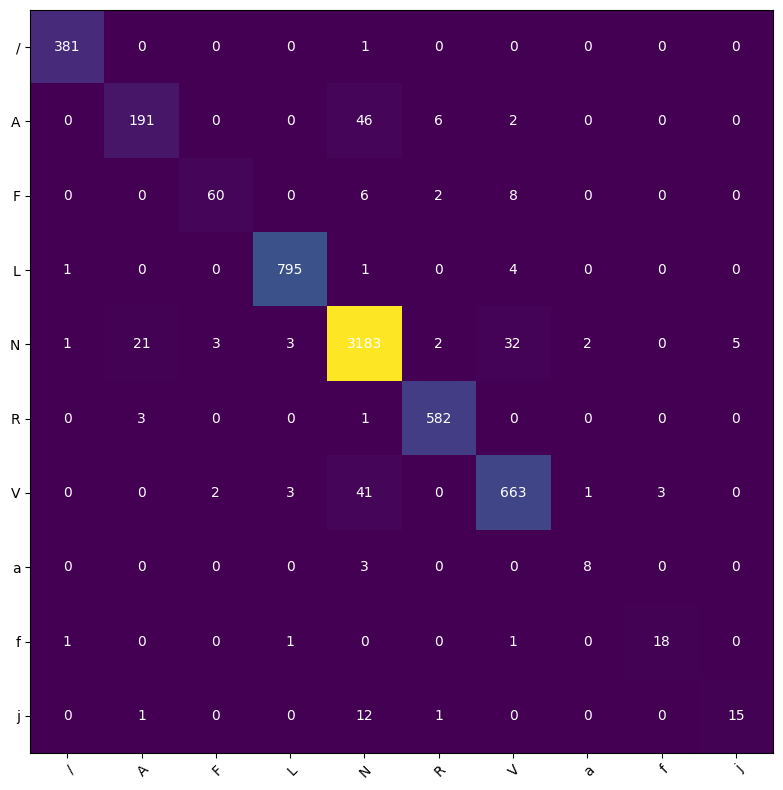

In [50]:
def process_testing_data(data_file):
    LABELED_TFREC_FORMAT = {
            "image_id": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            'target10': tf.io.FixedLenFeature([], tf.int64),
            'gender' : tf.io.FixedLenFeature([], tf.int64),
            'age_interval' : tf.io.FixedLenFeature([], tf.int64),
        }
    data = tf.io.parse_single_example(data_file, LABELED_TFREC_FORMAT)
    img = tf.image.decode_jpeg(data['image'], channels=1)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [*IMG_TRAIN_SHAPE, 1])

    age = tf.cast(data['age_interval'], tf.float32) / 10.0
    sex = tf.cast(data['gender'], tf.float32) / 1.0
    tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
    tabular_data = tf.stack(tab_data)

    target10 = tf.one_hot(data['target10'], depth=10)
    image_id = data["image_id"]

    return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10, "image_id":  data['image_id']}

ignore_order = tf.data.Options()
TEST_FILES = sorted(tf.io.gfile.glob('/kaggle/input/mitdb128x128/mitdb_128x128/train*.tfrec'))[-1]
test_dataset = (
    tf.data.TFRecordDataset(
        TEST_FILES,
        num_parallel_reads=tf.data.experimental.AUTOTUNE
    ).with_options(
        ignore_order
    ).map(
        process_testing_data,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).batch(
        BATCH_SIZE *  4
    ).prefetch(
        tf.data.experimental.AUTOTUNE
    )
)


fold = 0
test_imgs = test_dataset.map(lambda data, ids: data)
img_labels_ds = test_dataset.map(lambda data, ids: ids).unbatch()

STEPS = (TOTAL_TEST_IMG)//(BATCH_SIZE*4) + 1

pred = model.predict(test_imgs,steps = int(STEPS), verbose=1)
# # pred = pred.squeeze()
test_labels = next(iter(img_labels_ds.batch(int(TOTAL_TEST_IMG) + 1)))
pd.DataFrame({
        'image_id'  : test_labels["image_id"].numpy(),
        'actual'  : np.argmax(test_labels["target10"].numpy(), axis=1),
        'predicted'      : np.argmax(pred, axis=1)
        }).to_csv('prediction_{}.csv'.format(fold + 1), index=False)

df = pd.read_csv("prediction_{}.csv".format(fold + 1))



NAME = ['/', "A",  'F', 'L', 'N', 'R', 'V', 'a', 'f', 'j']
harvest = confusion_matrix(df['actual'], df['predicted'])
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(harvest)
ax.set_xticks(np.arange(len(NAME)))
ax.set_yticks(np.arange(len(NAME)))
ax.set_xticklabels(NAME)
ax.set_yticklabels(NAME)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

for i in range(len(NAME)):
    for j in range(len(NAME)):
        text = ax.text(j, i, harvest[i, j],
                    ha="center", va="center", color="w")

fig.tight_layout()

from sklearn.metrics import classification_report
target_names = NAME
x_ = classification_report(df['actual'], df['predicted'], target_names=target_names)
print(x_)

In [9]:
print(x_) # with meta data mobilenetv1 -> 261k

              precision    recall  f1-score   support

           /       1.00      1.00      1.00       382
           A       0.91      0.82      0.86       245
           F       0.89      0.72      0.80        76
           L       0.98      0.99      0.99       801
           N       0.97      0.99      0.98      3252
           R       0.99      0.99      0.99       586
           V       0.95      0.91      0.93       713
           a       0.78      0.64      0.70        11
           f       0.95      0.90      0.93        21
           j       0.74      0.90      0.81        29

    accuracy                           0.97      6116
   macro avg       0.92      0.89      0.90      6116
weighted avg       0.97      0.97      0.97      6116



In [15]:
!cp /kaggle/working/model-0.h5 /kaggle/working/model-0-b.h5

In [6]:
wandb.finish()